In [1]:
# dependencies
%matplotlib inline
from matplotlib import style
style.use('seaborn-whitegrid')
import matplotlib.pyplot as plt
import proplot as pplt
import numpy as np
import pandas as me
import datetime as dt
from datetime import datetime, timedelta

#### Reflect Tables into SQLAlchemy ORM

In [2]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, inspect, func

In [3]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [4]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)

In [5]:
# view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [6]:
# save references to each table
measurement = Base.classes.measurement
station = Base.classes.station

In [7]:
# create session from Python to the db
session = Session(engine)

#### Exploratory Precipitation Analysis

In [8]:
# find the last date in the data set and make variable to allow changes in data (i.e. additional future dates)
last_date = session.query(func.max(measurement.date))[0]
last_date = dt.datetime.strptime(last_date[0], "%Y-%m-%d").date()
print(last_date)

2017-08-23


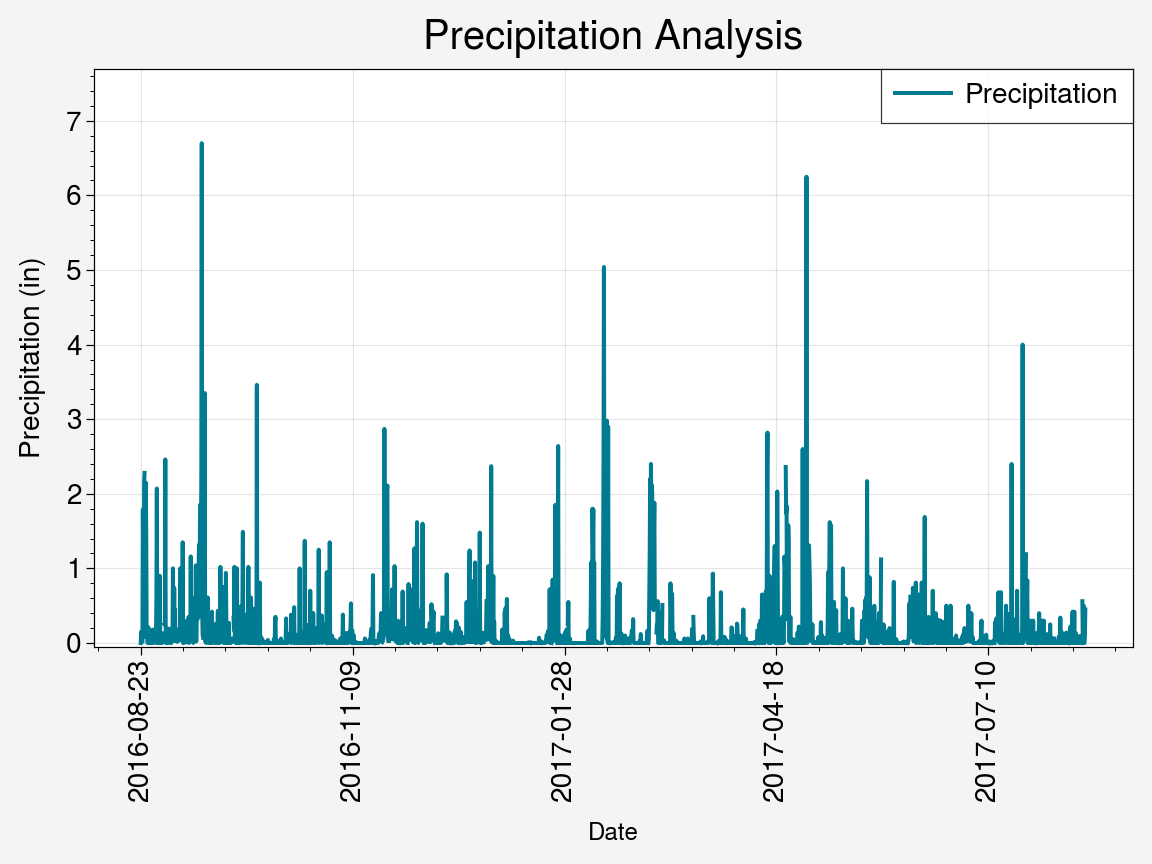

In [9]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# calculate the date one year from the last date in data set.
prev_year = (last_date) - dt.timedelta(days=365)

# perform a query to retrieve the data and precipitation scores
prcp_data = session.query(measurement.date, measurement.prcp)\
            .filter(measurement.date >= prev_year)\
            .order_by(measurement.date).all()

# save the query results as a pandas dataframe and set the index to the date column
prcp_df = me.DataFrame(prcp_data, columns=['Date', 'Precipitation'])
prcp_df.set_index('Date', inplace=True)

# ensure dates are ordered from earliest (set by prev_year) and latest (last_date)
prcp_df.sort_index()

# # set dates with no precip. data to 0 for connected lines on chart
# # prcp_df = prcp_df.fillna(0)
# print(prcp_df.head(5))

# set y-limit to 1 more than highest precip value
prcp_max = prcp_df['Precipitation'].max() + 1

# create chart using matplotlib
prcp_df.plot(title="Precipitation Analysis", 
             figsize=(8,6),
             linewidth=2, 
             rot=90,
             color='xkcd:ocean')
plt.xticks(fontsize=14)
plt.xlabel('Date',fontsize=12, color='black', labelpad=10)
plt.ylim(-0.05,prcp_max)
plt.yticks(size=14)
plt.ylabel('Precipitation (in)',fontsize=14, color='black', labelpad=10)
plt.title('Precipitation Analysis',fontsize=20, color='black', pad=10)
plt.legend(loc='upper right', fontsize=14)
plt.tight_layout()
plt.savefig('Images/precip_analysis.png')
plt.show()

In [10]:
# Use pandas to calcualte the summary statistics for the precipitation data
prcp_df.describe()

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


#### Exploratory Station Analysis

In [11]:
# design a query to calculate the total number stations in the dataset
station_count = session.query(measurement.station).distinct().count()
station_count

9

In [12]:
# query to find the most active stations
# list the stations and the counts in descending order.
active_stations = session.query(measurement.station, func.count(measurement.station))\
                        .group_by(measurement.station)\
                        .order_by(func.count(measurement.station).desc()).all()

# get most active station and set to variable, index 0,0 as previous result sorted high to low
most_active_station = active_stations[0][0]
print(active_stations)
print(f'\nThe most active station is Station {most_active_station}')

[('USC00519281', 2772), ('USC00519397', 2724), ('USC00513117', 2709), ('USC00519523', 2669), ('USC00516128', 2612), ('USC00514830', 2202), ('USC00511918', 1979), ('USC00517948', 1372), ('USC00518838', 511)]

The most active station is Station USC00519281


In [13]:
# using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
sel = [func.min(measurement.tobs),
       func.max(measurement.tobs),
       func.avg(measurement.tobs)]

minmax_avg = session.query(*sel)\
    .filter(measurement.station == most_active_station).all()
print(minmax_avg)

[(54.0, 85.0, 71.66378066378067)]


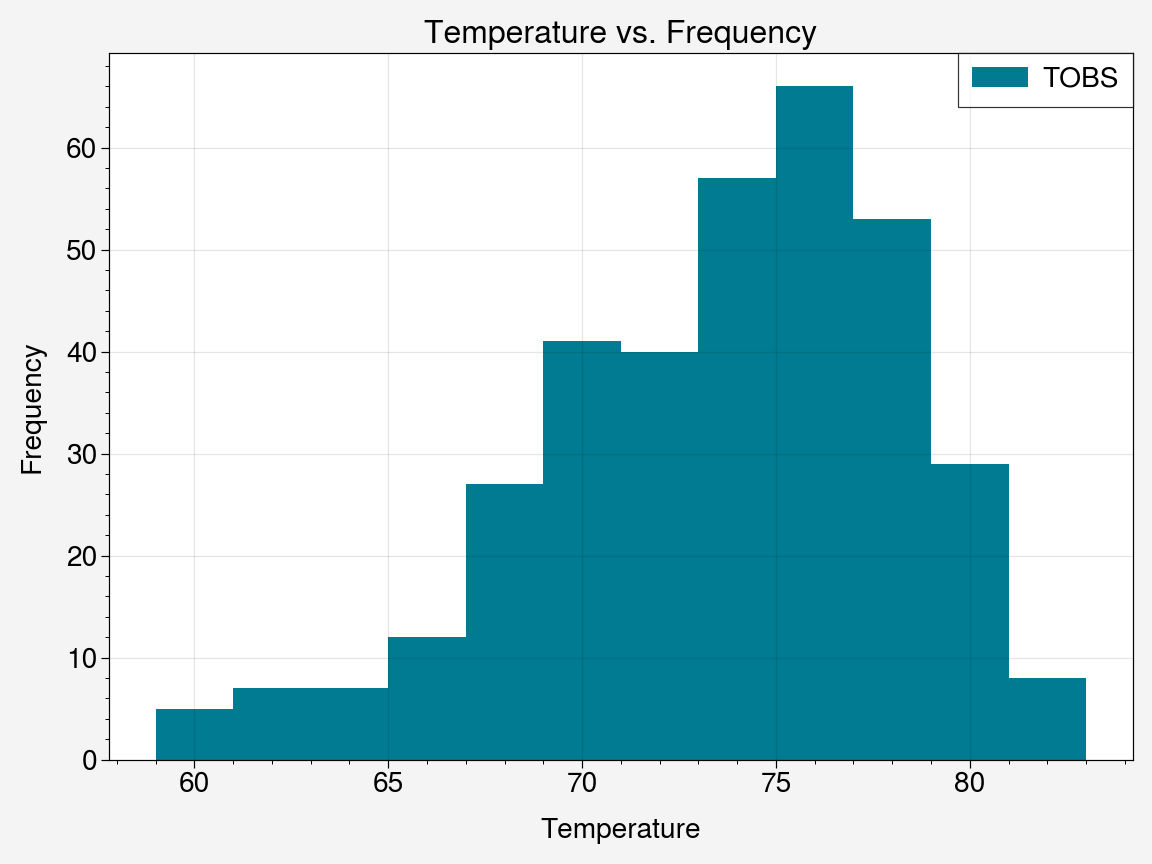

In [14]:
# using the most active station id, query the last 12 months of temperature observation data for this station and plot the results as a histogram
tobs_data = session.query(measurement.tobs)\
            .filter(measurement.date >= prev_year)\
            .filter(measurement.station == most_active_station)\
            .order_by(measurement.date).all()

# create dataframe for TOBS data
tobs_df = me.DataFrame(tobs_data, columns=['TOBS'])

# create histogram from data
tobs_df.plot.hist(bins=12,
                  figsize=(8,6),
                  color='xkcd:ocean',
                  alpha=1)
plt.title('Temperature vs. Frequency',fontsize=16,color='black')
plt.xticks(fontsize=14)
plt.xlabel('Temperature',fontsize=14, color='black', labelpad=10)
plt.yticks(size=14)
plt.ylabel('Frequency',fontsize=14, color='black', labelpad=10)
plt.legend(loc='upper right', fontsize=14)
plt.tight_layout()
plt.savefig('Images/temp_vs_freq.png')
plt.show()



### Close Session

In [15]:
# close Session
session.close()